### Setup

This notebook explains how to to access the dataset models from django.
The datasets are loaded from the Postgres database into pandas dataframes.

To start the notebook server:

```
# Start a bash shell inside the api container
docker-compose exec api /bin/bash

# Start the jupyter notebook
python manage.py shell_plus --notebook

# Take note of the token provided and access the notebook through:
<ip-of-the-machine>:7777/?<token>
http://127.0.0.1:7777/?token=30c43675981e671b4a609cff470819098e274bbde415b7f5
```

This step has only to be made once as long as the jupyter-notebook keeps executing.
Considering that the the notebook continues to run, you can access the notebook using:
``` 
<ip-of-the-machine>:7777/?<token>
```

### Load libraries and database models

In [1]:
# Required to access the database
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

In [2]:
# Data analysis tools
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
# Models available in our application
from datasets.models import RawFlower, RawUNM, RawDAR
from django.contrib.auth.models import User

## Accessing a model and its elements

In [4]:
# This returns a QuerySet... not very usefull for
# our standard data analysis tools
RawUNM.objects.all()

<QuerySet [<RawUNM: RawUNM object (1)>, <RawUNM: RawUNM object (2)>, <RawUNM: RawUNM object (3)>, <RawUNM: RawUNM object (4)>, <RawUNM: RawUNM object (5)>, <RawUNM: RawUNM object (6)>, <RawUNM: RawUNM object (7)>, <RawUNM: RawUNM object (8)>, <RawUNM: RawUNM object (9)>, <RawUNM: RawUNM object (10)>, <RawUNM: RawUNM object (11)>, <RawUNM: RawUNM object (12)>, <RawUNM: RawUNM object (13)>, <RawUNM: RawUNM object (14)>, <RawUNM: RawUNM object (15)>, <RawUNM: RawUNM object (16)>, <RawUNM: RawUNM object (17)>, <RawUNM: RawUNM object (18)>, <RawUNM: RawUNM object (19)>, <RawUNM: RawUNM object (20)>, '...(remaining elements truncated)...']>

In [5]:
# The Harmonized dataset has one analyte per entry.
# Thus the analytes associated with a patient are distributed accross different users
RawUNM._meta.get_fields()

(<django.db.models.fields.AutoField: id>,
 <django.db.models.fields.CharField: PIN_Patient>,
 <django.db.models.fields.CharField: Member_c>,
 <django.db.models.fields.CharField: TimePeriod>,
 <django.db.models.fields.CharField: Analyte>,
 <django.db.models.fields.FloatField: Result>,
 <django.db.models.fields.FloatField: Creat_Corr_Result>)

In [6]:
df = pd.DataFrame.from_records(
    RawUNM.objects.values()
)
df.head()

,id,PIN_Patient,Member_c,TimePeriod,Analyte,Result,Creat_Corr_Result
0,1,A0000M,1,1,BCD,1.877245,-99999.0
1,2,A0001M,1,1,BCD,1.458583,-99999.0
2,3,A0002M,1,1,BCD,1.694041,-99999.0
3,4,A0002M,1,1,BCD,1.401296,-99999.0
4,5,A0003M,1,1,BCD,0.763068,-99999.0


### There is an adapter to access the model as a Pandas DataFrame

In [7]:
# This adapter pivots the dataset so that each patient has all its analytes in the same row
#   obs: this may change in the future
from api import adapters
df = adapters.unm.get_dataframe()
df.head()

Analyte,TimePeriod,Member_c,BCD,BHGE,BHGM,BMN,BPB,BSE,IHG,SCU,...,UPB,UPT,USB,USN,USR,UTAS,UTL,UTMO,UTU,UUR
PIN_Patient,,,,,,,,,,,,,,,,,,,,,
A0000M,1,1,1.877245,0.986032,0.286189,29.951004,11.286068,221.243518,0.238399,194.123746,...,5.130511,0.023419,2.093974,104.864891,210.843380,NaN,0.407934,0.315638,1.095520,0.424221
A0000M,3,1,1.917757,0.960096,0.281482,39.625520,13.130241,93.609337,1.547092,320.035756,...,6.181337,0.283413,0.369532,46.501138,242.420790,40.412493,0.330801,0.837639,4.549155,0.067877
A0001M,1,1,1.458583,0.766354,0.267237,37.544422,6.263336,141.446559,1.028667,283.629828,...,6.344290,0.027268,0.111157,128.722640,539.955495,72.518513,0.408528,0.514317,1.262910,1.554346
A0001M,3,1,1.365789,0.733911,0.556805,18.177618,13.484152,169.320118,0.805577,453.702953,...,2.585459,0.418031,0.374565,76.349240,632.283089,76.423963,0.149195,0.143302,1.692582,0.020716
A0002M,1,1,1.547669,1.055360,1.249391,28.708556,6.879870,148.052499,1.779297,NaN,...,4.512958,0.016849,2.194181,119.393236,878.090138,184.791202,0.165174,0.387643,0.988567,1.081877


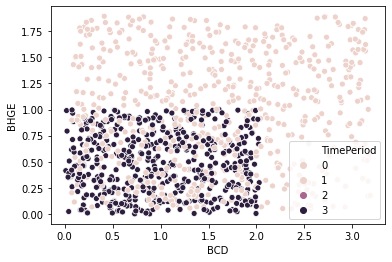

In [8]:
# plotting can now be done with pre-installed libraries that operate with pandas DataFrames
ax = sns.scatterplot(data=df, x='BCD', y='BHGE', hue='TimePeriod')

### Under the hood this is what is going on

In [9]:
# These are the steps of adapters.unm.get_dataframe() function

# Load the unpivot dataframe
df = pd.DataFrame.from_records(
    RawUNM.objects.values()
)

# Select the correct variables to pivot
numerical_values = 'Result'
columns_to_indexes = ['PIN_Patient', 'TimePeriod', 'Member_c']
categorical_to_columns = ['Analyte']
indexes_to_columns = ['Member_c', 'TimePeriod']

# Perform the pivot operation
df = pd.pivot_table(df, values=numerical_values,
                    index=columns_to_indexes,
                    columns=categorical_to_columns,
                    aggfunc=np.average)
df = df.reset_index(level=indexes_to_columns)
df.head()

Analyte,TimePeriod,Member_c,BCD,BHGE,BHGM,BMN,BPB,BSE,IHG,SCU,...,UPB,UPT,USB,USN,USR,UTAS,UTL,UTMO,UTU,UUR
PIN_Patient,,,,,,,,,,,,,,,,,,,,,
A0000M,1,1,1.877245,0.986032,0.286189,29.951004,11.286068,221.243518,0.238399,194.123746,...,5.130511,0.023419,2.093974,104.864891,210.843380,NaN,0.407934,0.315638,1.095520,0.424221
A0000M,3,1,1.917757,0.960096,0.281482,39.625520,13.130241,93.609337,1.547092,320.035756,...,6.181337,0.283413,0.369532,46.501138,242.420790,40.412493,0.330801,0.837639,4.549155,0.067877
A0001M,1,1,1.458583,0.766354,0.267237,37.544422,6.263336,141.446559,1.028667,283.629828,...,6.344290,0.027268,0.111157,128.722640,539.955495,72.518513,0.408528,0.514317,1.262910,1.554346
A0001M,3,1,1.365789,0.733911,0.556805,18.177618,13.484152,169.320118,0.805577,453.702953,...,2.585459,0.418031,0.374565,76.349240,632.283089,76.423963,0.149195,0.143302,1.692582,0.020716
A0002M,1,1,1.547669,1.055360,1.249391,28.708556,6.879870,148.052499,1.779297,NaN,...,4.512958,0.016849,2.194181,119.393236,878.090138,184.791202,0.165174,0.387643,0.988567,1.081877


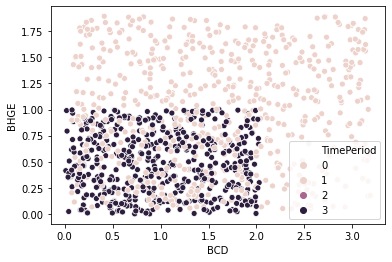

In [10]:
# plotting can now be done with pre-installed libraries that operate with pandas DataFrames
ax = sns.scatterplot(data=df, x='BCD', y='BHGE', hue='TimePeriod')